In [ ]:
from configparser import ConfigParser

config = ConfigParser()
config.read('config.ini')
config['augmentations']['pad_trunc_noise_multiplier']


In [ ]:
from torchsummary import summary
summary(model, (1,257, 63))

In [ ]:
import torch
from loader.AudioDataset import specMask, collate_batch, createDataset
from torch.utils.data import Dataset
import loader.utils as utils
import matplotlib.pyplot as plt
import model
import random

random.seed(10)
torch.manual_seed(10)

linux = '/media/jianquan/Data/Processed Audio/'
windows = 'E:/Processed Audio/'

audio_paths, _ = utils.getAudioPaths(windows)

audio_train_dataset = createDataset(audio_paths, transformParams = utils.getTransforms(False), outputAudio = True)

test_dataloader = torch.utils.data.DataLoader(
    audio_train_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_batch
)
batch = next(iter(test_dataloader))
batch_size = len(batch[0])

nfftList = [64, 128, 256, 512, 1024]
classList = [0, 1, 2]

for nfft in nfftList:
    for specClass in classList:
        saveName = f'nfft{nfft}_class{specClass}'
        print(saveName, end=': ')
        testModel = model.CNNNetwork(nfft, specClass)
        testModel(batch[0])
        plt.savefig(f'./spec/spec/whisper Norm/{saveName}.png')


# import IPython.display as ipd
# ipd.Audio(batch[0][3], rate = 8000)
# for b in batch[0]:
#     # print(b.max(),b.median(),b.mean(), b.min())
#     # print(b).

    
#     plt.plot(b[0])
#     plt.show()

In [1]:
import torch
import matplotlib.pyplot as plt
import testModel

windowLength = 2

gt_x, gt_y = testModel.getGroundTruth('./data/1speaker_0.txt', windowLength, 840)
gt_x = gt_x[0:10]
gt_y = gt_y[0:10]
pred_graph=torch.randint(2,[int(gt_x[-1]/windowLength)])


C:\Users\jianq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0, 9.845261, 15.917279, 21.873197, 26.447528, 27.829116, 29.715737, 56.33161, 58.015057, 59.094785]
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


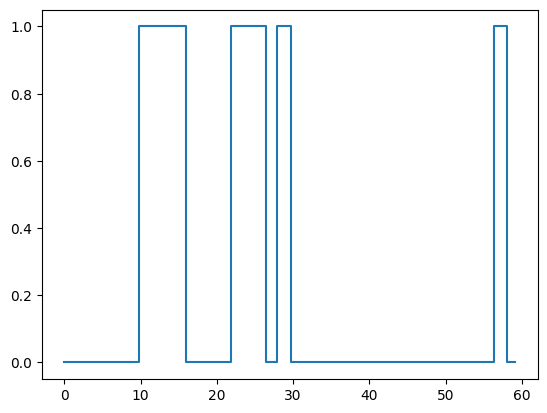

In [2]:
plt.step(gt_x, gt_y)
print(gt_x)
print(gt_y)
# plt.step(torch.arange(len(pred_graph))*windowLength, pred_graph)

In [71]:
import numpy as np
import enum

gt_x = np.array(gt_x)
gt_y = np.array(gt_y)

class filterMode(enum.Enum):
    Class_0 = 0
    Class_1 = 1
    Class_2 = 2
    Occupancy = 3

def get_percentage_in_window(startTime, endTime):
    label_time = np.array([0.0,0.0,0.0])
    overlap = np.logical_and([gt_x > startTime],[gt_x<=endTime])
    overlapIndex = overlap.nonzero()[1]

    if len(overlapIndex):
        lastTime = startTime
        for overlap in overlapIndex:
            label_time[gt_y[overlap]] += gt_x[overlap] - lastTime
            lastTime = gt_x[overlap]
        label_time[gt_y[overlap+1]] += endTime-gt_x[overlap]
    else:
        label_time[gt_y[np.argmax(gt_x > endTime)]] = endTime-startTime
    label_time=label_time/(endTime-startTime)
    assert np.sum(label_time) == 1
    return label_time

def percentageMode(occupancy_label, mode: enum):
    if mode == filterMode.Occupancy:
        return occupancy_label.argmax()
    print(np.where(occupancyPercentage!=0)[0] == mode.value)
    

get_percentage_in_window(8,10)

array([False,  True])

In [57]:
occupancyPercentage = get_percentage_in_window(8,10)
print(occupancyPercentage)
percentageMode(occupancyPercentage, filterMode.Class_1)

[0.9226305 0.0773695 0.       ]
1
False


In [66]:
np.array([0,1])

array([0, 1])

In [ ]:
for i, pred in enumerate(pred_graph):
    windowStart, windowEnd = i* windowLength, (i+1)*windowLength
    

In [ ]:
import torch

torch.range(0, 4, 2)

In [21]:
import requests
from bs4 import BeautifulSoup

URL = "https://www.carousell.sg/categories/free-items-1898/?addRecent=false&canChangeKeyword=false&includeSuggestions=false&sc=0a0208301a0408bbe1722a170a0b636f6c6c656374696f6e7312060a043138393878013204080378013a02180742060801100118004a0620012801400150005a020801&searchId=_EmsGs&sort_by=3&t-id=eVYfpwa4W-_1669549714514&t-source=featured_categories_sidebar"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")
results = soup.find(id="D_gT D_aHY")
results

In [18]:
job_elements = results.find_all("div", class_="card-content")

AttributeError: 'NoneType' object has no attribute 'find_all'

In [16]:
job_elements[0]
print(soup)

<!DOCTYPE html>

<html>
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>Fake Python</title>
<link href="https://cdn.jsdelivr.net/npm/bulma@0.9.2/css/bulma.min.css" rel="stylesheet"/>
</head>
<body>
<section class="section">
<div class="container mb-5">
<h1 class="title is-1">
        Fake Python
      </h1>
<p class="subtitle is-3">
        Fake Jobs for Your Web Scraping Journey
      </p>
</div>
<div class="container">
<div class="columns is-multiline" id="ResultsContainer">
<div class="column is-half">
<div class="card">
<div class="card-content">
<div class="media">
<div class="media-left">
<figure class="image is-48x48">
<img alt="Real Python Logo" src="https://files.realpython.com/media/real-python-logo-thumbnail.7f0db70c2ed2.jpg?__no_cf_polish=1"/>
</figure>
</div>
<div class="media-content">
<h2 class="title is-5">Senior Python Developer</h2>
<h3 class="subtitle is-6 company">Payne, Roberts and Davis</h3>
</div>
</div>